In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import tensorflow as tf

%matplotlib inline

Content Image --> Louvre Museum (Paris/FRANCE) (1, 300, 400, 3)


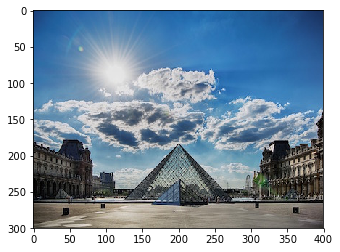

In [2]:
content_image = np.array(plt.imread('images/louvre_small.jpg'))
plt.imshow(content_image)
content_image = np.expand_dims(content_image,axis=0)
content_image = content_image - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
print("Content Image --> Louvre Museum (Paris/FRANCE)",content_image.shape)

Style Image --> Impressionist (Claude Monet) (1, 300, 400, 3)


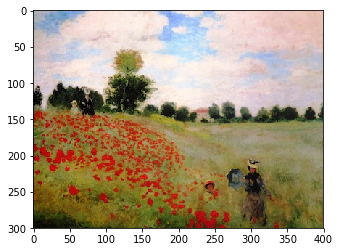

In [3]:
style_image = np.array(plt.imread('images/monet.jpg'))
plt.imshow(style_image)
style_image = np.expand_dims(style_image,axis=0)
style_image = style_image - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
print('Style Image --> Impressionist (Claude Monet)',style_image.shape)

In [4]:
def Load_Model(file_path):
    
    vgg_model = scipy.io.loadmat(file_path)
    model_layers = vgg_model['layers']
    
    def Weight_And_Bias(layer):
        
        wb = model_layers[0][layer][0][0][2]
        W = np.array(wb[0][0])
        b = np.array(wb[0][1])
        
        return W,b
    
    def Conv2D_Helper(A_prev,layer):
        
        W,b = Weight_And_Bias(layer)
        b = b.reshape((1,1,1,b.shape[0]))
        A = tf.add(tf.nn.conv2d(A_prev,W,strides=[1, 1, 1, 1],padding='SAME'),tf.convert_to_tensor(b))
        
        return A
    
    model = {}
    model['input'] = tf.Variable(np.zeros(shape=(1,300,400,3),dtype='float32'))
    model['conv1_1'] = tf.nn.relu(Conv2D_Helper(model['input'],0))
    model['conv1_2'] = tf.nn.relu(Conv2D_Helper(model['conv1_1'],2))
    model['avgpool1'] = tf.nn.avg_pool(model['conv1_2'],ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    model['conv2_1'] = tf.nn.relu(Conv2D_Helper(model['avgpool1'],5))
    model['conv2_2'] = tf.nn.relu(Conv2D_Helper(model['conv2_1'],7))
    model['avgpool2'] = tf.nn.avg_pool(model['conv2_2'],ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    model['conv3_1'] = tf.nn.relu(Conv2D_Helper(model['avgpool2'],10))
    model['conv3_2'] = tf.nn.relu(Conv2D_Helper(model['conv3_1'],12))
    model['conv3_3'] = tf.nn.relu(Conv2D_Helper(model['conv3_2'],14))
    model['conv3_4'] = tf.nn.relu(Conv2D_Helper(model['conv3_3'],16))
    model['avgpool3'] = tf.nn.avg_pool(model['conv3_4'],ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    model['conv4_1'] = tf.nn.relu(Conv2D_Helper(model['avgpool3'],19))
    model['conv4_2'] = tf.nn.relu(Conv2D_Helper(model['conv4_1'],21))
    model['conv4_3'] = tf.nn.relu(Conv2D_Helper(model['conv4_2'],23))
    model['conv4_4'] = tf.nn.relu(Conv2D_Helper(model['conv4_3'],25))
    model['avgpool4'] = tf.nn.avg_pool(model['conv4_4'],ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    model['conv5_1'] = tf.nn.relu(Conv2D_Helper(model['avgpool4'],28))
    model['conv5_2'] = tf.nn.relu(Conv2D_Helper(model['conv5_1'],30))
    model['conv5_3'] = tf.nn.relu(Conv2D_Helper(model['conv5_2'],32))
    model['conv5_4'] = tf.nn.relu(Conv2D_Helper(model['conv5_3'],34))
    model['avgpool5'] = tf.nn.avg_pool(model['conv5_4'],ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    return model

In [5]:
def Content_Image_Activation(model,layer):
    
    sess.run(model['input'].assign(content_image))
    a_C = sess.run(model[layer])
    
    return a_C

In [6]:
def Compute_Content_Cost(a_C,a_G):
    
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    a_C = tf.transpose(tf.reshape(a_C,shape=(m,n_H*n_W,n_C)))
    a_G = tf.transpose(tf.reshape(a_G,shape=(m,n_H*n_W,n_C)))
    
    J_content = tf.reduce_sum(tf.square(a_C-a_G))/(4*n_H*n_W*n_C)
    
    return J_content

In [7]:
def Content_Cost_Helper(model,layer,a_C):
    
    a_C = tf.convert_to_tensor(a_C)
    
    a_G = model[layer]
    J_content = Compute_Content_Cost(a_C,a_G)
    
    return J_content

In [8]:
def cal(model):
    
    val = {}
    for i in range(5):
        name = 'conv'+str(i+1)+'_1'
        val[name] = model[name]
        
    return val

In [9]:
def Style_Image_Activation(model,style_layers):
    
    a_S_list = {}

    for name,val in style_layers:
        sess = tf.Session()
        sess.run(model['input'].assign(style_image))
        a_S_list[name] = sess.run(model[name])
        sess.close()
    
    return a_S_list

In [10]:
def Compute_Style_Cost(a_S,a_G):
    
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,shape=(1,n_H*n_W,n_C)))
    a_G = tf.transpose(tf.reshape(a_G,shape=(1,n_H*n_W,n_C)))
    
    GS = tf.tensordot(a_S,tf.transpose(a_S),axes=1)
    GG = tf.tensordot(a_G,tf.transpose(a_G),axes=1)
    
    J_style_layer = tf.reduce_mean(tf.square(GG-GS))/np.square(2*n_H*n_W*n_C)
    
    return J_style_layer

In [11]:
def Style_Cost_Helper(model,style_layers):
    
    J_style = 0.0
    
    for name,val in style_layers:
        out = model[name]
        a_S = sess.run(out)
        a_G = out
        J_style += val*Compute_Style_Cost(tf.convert_to_tensor(a_S),a_G)
    
    return J_style

In [12]:
def Total_Cost(J_content,J_style,alpha,beta):
    
    J = alpha*tf.cast(J_content,'float32') + beta*J_style
    return J

In [13]:
def Generate_Noise_Image(noise_ratio):
    
    generated_image = np.random.uniform(-20,20,size=(1,300,400,3))
    generated_image = noise_ratio*generated_image + (1-noise_ratio)*content_image
    
    return generated_image

In [14]:
def save_image(path, image):
    
    image = image + np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imsave(path, image)

In [15]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [32]:
def Model(model,file_path,style_layers,noise_ratio,epochs,learning_rate,alpha,beta,layer):
    
    generated_image = Generate_Noise_Image(noise_ratio)
    print(generated_image)
    
    a_C = Content_Image_Activation(model,layer)
    J_content = Content_Cost_Helper(model,layer,a_C)
    
    sess.run(model['input'].assign(style_image))
    J_style = Style_Cost_Helper(model,style_layers)
    
    J = Total_Cost(J_content,0,alpha,beta)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(J)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    sess.run(model['input'].assign(generated_image))
    
    for i in range(epochs):
        _,generated_image = sess.run([optimizer,model['input']])
        
        print("---------------------------End of Iteration "+str(i)+'-------------------------------\n')
        print("Cost = ",sess.run(J_content))
        if(i%2 == 0):
            save_image("output/NST_content_image" + str(i) + ".jpg", generated_image)
    
    save_image("output/Artistic_image.jpg",generated_image)
    
    return generated_image

In [30]:
def Caller_Function():
    
    file_path = "pretrained-model/imagenet-vgg-verydeep-19.mat"
    model = Load_Model(file_path)
    style_layers = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]
    noise_ratio = 0.6
    epochs = 20
    learning_rate = 2.0
    alpha = 20.0
    beta = 40.0
    layer = 'conv4_2'
    #a_S_list = Style_Image_Activation(model,style_layers)
    
    generated_image = Model(model,file_path,style_layers,noise_ratio,epochs,learning_rate,alpha,beta,layer)
    print(generated_image)
    plt.imshow(generated_image[0])

---------------------------End of Iteration 0-------------------------------

Cost =  5946.84
---------------------------End of Iteration 1-------------------------------

Cost =  5121.47
---------------------------End of Iteration 2-------------------------------

Cost =  4497.45
---------------------------End of Iteration 3-------------------------------

Cost =  4055.2
---------------------------End of Iteration 4-------------------------------

Cost =  3703.64
---------------------------End of Iteration 5-------------------------------

Cost =  3406.31
---------------------------End of Iteration 6-------------------------------

Cost =  3150.89
---------------------------End of Iteration 7-------------------------------

Cost =  2929.06
---------------------------End of Iteration 8-------------------------------

Cost =  2733.69
---------------------------End of Iteration 9-------------------------------

Cost =  2561.55
---------------------------End of Iteration 10---------------

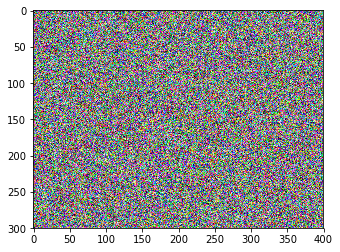

In [31]:
Caller_Function()